## ProLIF
https://prolif.readthedocs.io/en/stable/source/modules/interaction-fingerprint.html#prolif.fingerprint.Fingerprint.run_from_iterable

In [1]:
import MDAnalysis as mda
import prolif as plf
from rdkit import DataStructs
from pathlib import Path
import os
import re
import pandas as pds

In [2]:
def find_innermost_directories(root_dir):
    innermost_directories = []
    for root, dirs, _ in os.walk(root_dir):
        if not dirs:
            innermost_directories.append(root)
    return innermost_directories

# Find files that end with str file_end in a directory
def find_end_with_files(file_end, directory):
    ligand_sdf_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(file_end):
                ligand_sdf_files.append(os.path.join(root, file))
    return ligand_sdf_files


In [3]:
# Return list of files with prepared ligands
def find_prepped_ligs(root_dir):
    # Get a list of all prepared ligands, save in ligand_sdf_files
    file_end = 'ligand.sdf'
    innermost_dirs = find_innermost_directories(root_dir)
    ligand_sdf_files = []
    for directory in innermost_dirs:
        ligand_sdf_files.extend(find_end_with_files(file_end, directory))
    return ligand_sdf_files

# Prepare all ligand files into molecule objects prolif can interact with
def load_ligs(ligand_sdf_files):
    # Read in all the ligands into a list for prolif
    ligands = []
    for lig_file in ligand_sdf_files:
        # Read sdf
        ligands.append(plf.sdf_supplier(lig_file)[0])
    return ligands

# Make a map of the sequence the ligands are being fed in (which is the index that it will generate fingerprint from)
def get_map_protein(path):
    ligand_sdf_files = find_prepped_ligs(path)
    lig_map = dict()
    for i in range(len(ligand_sdf_files)):
        lig_file = ligand_sdf_files[i]
        lig_pattern = r'_(lig_\d+)_ligand.sdf'
        match = re.search(lig_pattern, lig_file)
        # Handle cases in the processed original protein folder (somehow named different)
        if match == None:
            lig_pattern = r'/(lig_\d+)_protein_ligand.sdf'
            match = re.search(lig_pattern, lig_file)
        lig_map[i] = match.group(1)
    return lig_map

In [4]:
# Get a prepared protein
def get_prep_protein(rootdir): 
    # List of all the prepared proteins
    prot_prep_files = []
    prot_end = '.pdb'

    innermost_dirs = find_innermost_directories(rootdir)
    for directory in innermost_dirs:
        prot_prep_files.extend(find_end_with_files(prot_end, directory))
        
    # Just get the first prepared
    prep_prot = prot_prep_files[0]
    u = mda.Universe(prep_prot)
    protein_mol = plf.Molecule.from_mda(u, NoImplicit=False) # Allow use of implicit H since not all H explicitly listed
    return protein_mol

In [5]:
# Generate fingerprints for a protein with all its ligands
# Count indicate if want to have counts, count is boolean
def get_fingerprint_of_prot(rootdir,count=False):
    # Get the prepared protein
    protein_mol = get_prep_protein(rootdir)
    
    # Get a list of all prepared ligands, save in ligand_sdf_files
    ligand_sdf_files = find_prepped_ligs(rootdir)
    # Read in all the ligands into a list for prolif
    ligands = load_ligs(ligand_sdf_files)
        
    # use default interactions
    fp = plf.Fingerprint(count = count)
    # run on your poses
    fp.run_from_iterable(ligands, protein_mol)
    return fp

## Make bitmap for protein-ligand interaction
#### labeled with the name of the ligand

In [6]:
# make interaction map by loop through the ligands
def make_lig_bitmap(fp, lig_map):
    lig_inters = {}
    # Go through the map when traverse a ligand to find the interactions
    for key in fp.ifp:
        # Map of all iteractions for each ligand
        inter_map = {'Hydrophobic':0, 
                     'HBAcceptor':0, 
                     'HBDonor':0,
                     'Cationic':0, 
                     'Anionic':0,
                     'CationPi':0, 
                     'PiCation':0, 
                     'PiStacking':0, 
                     'VdWContact':0}
        for i in fp.ifp[key]:
            for j in fp.ifp[key][i]:
                for interact in inter_map:
                    if j == interact:
                        inter_map[interact] = 1
        lig = lig_map[key]
        lig_inters[lig] = inter_map
    return lig_inters

In [18]:
## For some reason NP_776018.1 did not have any prepared structure generate
prepped_prots = ['/home/pengs/fold_zika/prev_prepped/orig_prepped',
                '/home/pengs/fold_zika/prev_prepped/NP_722463.1_prepped',
                '/home/pengs/fold_zika/prev_prepped/NP_739587.2_prepped',
                '/home/pengs/fold_zika/prev_prepped/YP_001621843.1_prepped',
                '/home/pengs/fold_zika/prev_prepped/YP_001527884.1_prepped',
                '/home/pengs/fold_zika/prev_prepped/NP_740321.1_prepped',
                '/home/pengs/fold_zika/prev_prepped/YP_001531172.2_prepped']

In [19]:
# Dictionary to store fingerprints of proteins
prot_fp = dict()
# Dictionary to map ligands to their index in fingerprint
lig_maps = dict()

for prot_dir in prepped_prots:
    prot_pattern = r'.+/(.+)_prepped'
    match = re.search(prot_pattern, prot_dir)
    prot = match.group(1)
    print(prot)
    # Get fingerprint of prepped ligands of protein
    prot_fp[prot] = get_fingerprint_of_prot(prot_dir, count=True)
    # Map the ligands to their index
    lig_maps[prot] = get_map_protein(prot_dir)

orig


/home/pengs/miniconda3/envs/prolif/lib/python3.10/site-packages/MDAnalysis/converters/RDKit.py:473: UserWarning: No `bonds` attribute in this AtomGroup. Guessing bonds based on atoms coordinates
  warnings.warn(
[14:08:24] Explicit valence for atom # 0 N, 4, is greater than permitted
/home/pengs/miniconda3/envs/prolif/lib/python3.10/site-packages/MDAnalysis/converters/RDKit.py:501: UserWarning: Could not sanitize molecule: failed during step rdkit.Chem.rdmolops.SanitizeFlags.SANITIZE_PROPERTIES
  warnings.warn("Could not sanitize molecule: "


  0%|          | 0/76 [00:00<?, ?it/s]

NP_722463.1


[14:08:35] Explicit valence for atom # 0 N, 4, is greater than permitted


  0%|          | 0/77 [00:00<?, ?it/s]

NP_739587.2


[14:08:43] Explicit valence for atom # 0 N, 4, is greater than permitted


  0%|          | 0/56 [00:00<?, ?it/s]

YP_001621843.1


[14:08:52] Explicit valence for atom # 0 N, 4, is greater than permitted


  0%|          | 0/1 [00:00<?, ?it/s]

YP_001527884.1


[14:08:59] Explicit valence for atom # 0 N, 4, is greater than permitted


  0%|          | 0/55 [00:00<?, ?it/s]

NP_740321.1


[14:09:09] Explicit valence for atom # 0 N, 4, is greater than permitted


  0%|          | 0/77 [00:00<?, ?it/s]

YP_001531172.2


[14:09:17] Explicit valence for atom # 0 N, 4, is greater than permitted


  0%|          | 0/65 [00:00<?, ?it/s]

## Make interaction dictionaries of each ligand for each protein
### Compare the ligands between proteins

In [20]:
import numpy as np

In [21]:
prot_lig_bitmap = dict()

for prot in prot_fp:
    prot_lig_bitmap[prot] = make_lig_bitmap(prot_fp[prot], lig_maps[prot])

In [22]:
# Change the way to traverse through the dictionary from protein as main key to ligand
def prot_to_lig(prot_lig_map):
    # Ligand protein dicts
    lig_prot_map = dict()
    
    for prot in prot_lig_map:
        for lig in prot_lig_map[prot]:
            series_map = pds.Series(prot_lig_map[prot][lig])
            vector = np.array(series_map)
            # Append this to a ligand dictionary
            if lig in lig_prot_map:
                lig_prot_map[lig][prot] = vector
            else:
                lig_prot_map[lig] = dict()
                lig_prot_map[lig][prot] = vector
    return lig_prot_map

In [23]:
lig_prot_bitmap = prot_to_lig(prot_lig_bitmap)

## Getting the jaccard-similarity between the protein-ligand bitmaps/countmaps of each type of interaction
### Smaller values, more similar (jaccard value of 0 means same)

In [24]:
# https://www.featurebase.com/blog/tanimoto-similarity-in-featurebase#:~:text=The%20Tanimoto%20algorithm%20provides%20a,%2D%20%7CA%20%E2%88%A9%20B%7C).
# https://www.statology.org/jaccard-similarity-python/
from scipy.spatial import distance
import os
import matplotlib.pyplot as plt

### Traverse through ligands from different proteins and vectorizing the bitmaps to compare

## Not all ligands are prepared for all the proteins
### for now, only consider the ligands that are prepared in the original zikv ns2b3 structure

In [35]:
# Distance to zikv_ns2b3 binding of each ligand
def get_jaccard_distance(lig_prot_map):
    lig_dist_jaccard = dict()
    
    for lig in lig_prot_map:
        # Only consider the ligands found prepared in the original zikv ns2b3
        if len(lig_prot_map[lig]) < 6:
            continue
        # Store the distance in a dictionary
        lig_dist_jaccard[lig] = dict()
        # Store the difference to the original binding in a dictionary labeled with the protein name
        for prot in lig_prot_map[lig]:
            lig_dist_jaccard[lig][prot] = distance.jaccard(lig_prot_map[lig][prot],lig_prot_map[lig]['orig'])

    return lig_dist_jaccard
    

In [33]:
lig_prot_bitmap['lig_19'].keys()

dict_keys(['orig', 'NP_722463.1', 'NP_739587.2', 'YP_001527884.1', 'NP_740321.1', 'YP_001531172.2'])

In [34]:
lig_dist_jaccard = get_jaccard_distance(lig_prot_bitmap)
df_jaccard_bitmap = pds.DataFrame(lig_dist_jaccard)
df_jaccard_bitmap

KeyError: 'orig'

## Would like to make a plot of this

In [28]:
# Calculate mean, mode, and median of jaccard index value of ligand bitmap
bitmap_mean = df_jaccard_bitmap.mean(axis=0)
bitmap_mode = df_jaccard_bitmap.mode(axis=0)
bitmap_median = df_jaccard_bitmap.median(axis=0)

In [29]:
df_bitmap_plot = pds.concat([bitmap_mean, bitmap_median], axis=1)
df_bitmap_plot.columns = ['Mean', 'Median']

In [30]:
# Path to save the figures
fig_path = Path('/home/pengs/fold_zika/figs')

FileNotFoundError: [Errno 2] No such file or directory: '/home/pengs/fold_zika/figs/bitmap_prolif.png'

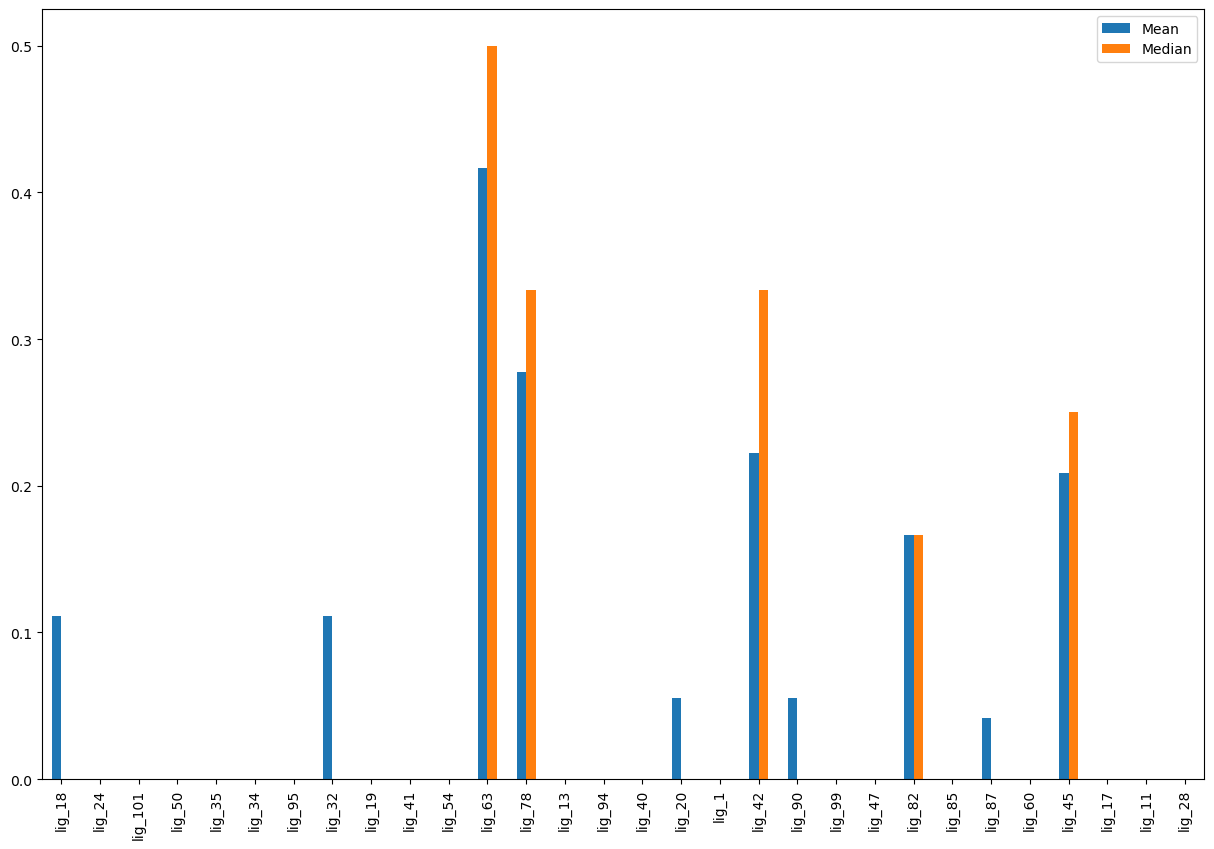

In [31]:
ax = df_bitmap_plot.plot.bar(figsize=(15,10))
fig = ax.get_figure()
fig.savefig(fig_path/'bitmap_prolif.png')

## Would like to remove 0 interactions (of ligands)

## Would like to make a count map as well

In [23]:
# Dictionary to store fingerprints of proteins
prot_count_fp = dict()
# Dictionary to map ligands to their index in fingerprint
lig_maps = dict()

for prot_dir in prepped_prots:
    prot_pattern = r'.+/(.+)_prepped'
    match = re.search(prot_pattern, prot_dir)
    prot = match.group(1)
    print(prot)
    # Get fingerprint of prepped ligands of protein
    prot_count_fp[prot] = get_fingerprint_of_prot(prot_dir, count=True)
    # Map the ligands to their index
    lig_maps[prot] = get_map_protein(prot_dir)

orig


/home/pengs/miniconda3/envs/asapdiscovery/lib/python3.10/site-packages/MDAnalysis/converters/RDKit.py:473: UserWarning: No `bonds` attribute in this AtomGroup. Guessing bonds based on atoms coordinates
  warnings.warn(
[16:00:13] Explicit valence for atom # 0 N, 4, is greater than permitted
/home/pengs/miniconda3/envs/asapdiscovery/lib/python3.10/site-packages/MDAnalysis/converters/RDKit.py:501: UserWarning: Could not sanitize molecule: failed during step rdkit.Chem.rdmolops.SanitizeFlags.SANITIZE_PROPERTIES
  warnings.warn("Could not sanitize molecule: "


  0%|          | 0/76 [00:00<?, ?it/s]

NP_722463.1


[16:00:36] Explicit valence for atom # 0 N, 4, is greater than permitted


  0%|          | 0/77 [00:00<?, ?it/s]

NP_739587.2


[16:00:55] Explicit valence for atom # 0 N, 4, is greater than permitted


  0%|          | 0/56 [00:00<?, ?it/s]

YP_001621843.1


[16:01:12] Explicit valence for atom # 0 N, 4, is greater than permitted


  0%|          | 0/1 [00:00<?, ?it/s]

YP_001527884.1


[16:01:22] Explicit valence for atom # 0 N, 4, is greater than permitted


  0%|          | 0/77 [00:00<?, ?it/s]

NP_740321.1


[16:01:40] Explicit valence for atom # 0 N, 4, is greater than permitted


  0%|          | 0/77 [00:00<?, ?it/s]

YP_001531172.2


[16:01:59] Explicit valence for atom # 0 N, 4, is greater than permitted


  0%|          | 0/77 [00:00<?, ?it/s]

In [24]:
# make interaction map by loop through the ligands
def make_lig_countmap(fp, lig_map):
    lig_inters = {}
    for key in fp.ifp:
        lig = lig_map[key]
        # Map of all iteractions for each ligand
        inter_map = {'Hydrophobic':0, 
                     'HBAcceptor':0, 
                     'HBDonor':0,
                     'Cationic':0, 
                     'Anionic':0,
                     'CationPi':0, 
                     'PiCation':0, 
                     'PiStacking':0, 
                     'VdWContact':0}
        # Change this to a pandas format to read
        df = fp.to_dataframe().T[key]
        # Iterate through the pandas series to find the interaction defined
        for item in df.iteritems():
            # The interaction
            inter = item[0][2]
            # The count of interaction
            count = item[1]
            # Find the corresponding interaction in the predefined interaction map
            for interact in inter_map:
                if inter == interact:
                    inter_map[interact] += count
        lig_inters[lig] = inter_map
    return lig_inters

In [25]:
prot_lig_countmap = dict()

for prot in prot_count_fp:
    prot_lig_countmap[prot] = make_lig_countmap(prot_count_fp[prot], lig_maps[prot])

/scratch/lsftmp/4730525.tmpdir/ipykernel_351964/2080076220.py:19: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for item in df.iteritems():
/scratch/lsftmp/4730525.tmpdir/ipykernel_351964/2080076220.py:19: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for item in df.iteritems():
/scratch/lsftmp/4730525.tmpdir/ipykernel_351964/2080076220.py:19: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for item in df.iteritems():
/scratch/lsftmp/4730525.tmpdir/ipykernel_351964/2080076220.py:19: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for item in df.iteritems():
/scratch/lsftmp/4730525.tmpdir/ipykernel_351964/2080076220.py:19: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for item in df.iteritems():
/scratch/lsftmp/4730

In [26]:
# Switch to traversal by ligand
lig_prot_countmap = prot_to_lig(prot_lig_countmap)

In [27]:
lig_dist_jaccard = get_jaccard_distance(lig_prot_countmap)
df_jaccard_countmap = pds.DataFrame(lig_dist_jaccard)
df_jaccard_countmap

,lig_18,lig_24,lig_7,lig_101,lig_9,lig_50,lig_8,lig_35,lig_34,lig_39,...,lig_60,lig_45,lig_17,lig_11,lig_81,lig_26,lig_49,lig_16,lig_12,lig_28
orig,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.00,0.0,0.000000,0.000000,0.0
NP_722463.1,0.666667,1.0,1.0,0.666667,0.333333,1.0,0.333333,0.5,1.0,1.0,...,1.0,0.750000,1.0,0.5,1.0,0.75,1.0,0.666667,0.666667,1.0
NP_739587.2,0.500000,1.0,1.0,0.666667,NaN,1.0,0.666667,1.0,0.5,1.0,...,1.0,0.750000,1.0,1.0,1.0,1.00,1.0,0.666667,0.666667,1.0
YP_001527884.1,1.000000,1.0,1.0,0.666667,0.666667,1.0,0.666667,1.0,1.0,1.0,...,1.0,0.666667,1.0,0.5,1.0,1.00,1.0,1.000000,0.666667,1.0
NP_740321.1,1.000000,1.0,1.0,0.666667,0.666667,1.0,0.666667,1.0,1.0,0.5,...,1.0,0.750000,1.0,0.5,0.5,0.50,1.0,0.666667,0.666667,0.5
YP_001531172.2,1.000000,1.0,1.0,0.666667,0.666667,1.0,0.666667,1.0,1.0,0.5,...,1.0,0.750000,1.0,1.0,0.5,0.75,1.0,0.666667,0.666667,1.0
YP_001621843.1,NaN,NaN,NaN,NaN,0.333333,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
# Calculate mean, mode, and median of jaccard index value of ligand bitmap
countmap_mean = df_jaccard_countmap.mean(axis=0)
countmap_mode = df_jaccard_countmap.mode(axis=0)
countmap_median = df_jaccard_countmap.median(axis=0)

In [29]:
df_countmap_plot = pds.concat([countmap_mean, countmap_median], axis=1)
df_countmap_plot.columns = ['Mean', 'Median']

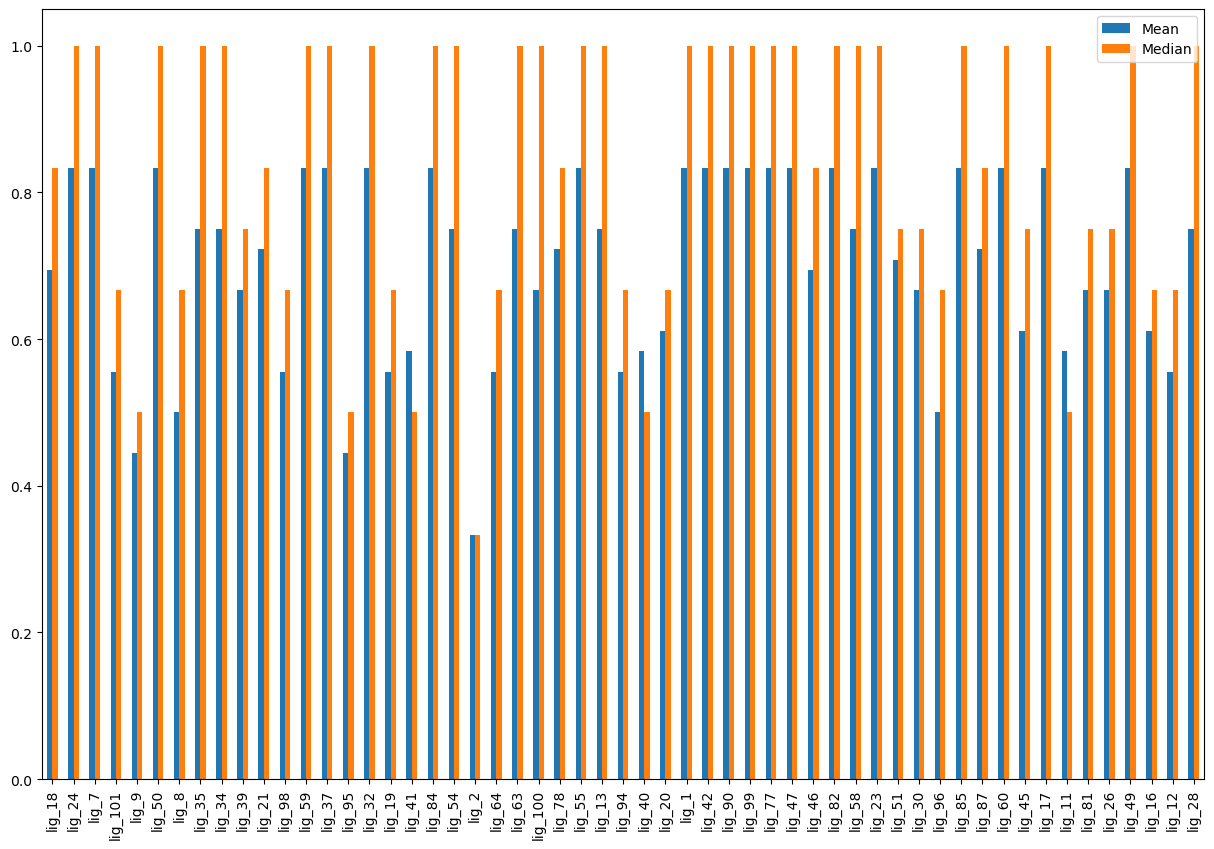

In [30]:
ax = df_countmap_plot.plot.bar(figsize=(15,10))
fig = ax.get_figure()
fig.savefig(fig_path/'countmap_prolif.png')

# TODO: 

## 1. Watch for 
- ligands without interactions
- ligands that have the same type of interaction but different residues

# Troubleshoot TODO:
## Pi-stacking
do a case study thing and show them side by side to see if they are where they should be
(lig_95)

In [30]:
for prot in prot_fp:
    df = prot_fp[prot].to_dataframe().T
    try:
        df.xs("PiStacking", level="interaction", axis=1)
    except TypeError:
        print('No PiStacking Found')

No PiStacking Found
No PiStacking Found
No PiStacking Found
No PiStacking Found
No PiStacking Found
No PiStacking Found
No PiStacking Found
